In [11]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint


In [12]:
time, w, m, c_0 = symbols("t w m c_0")
c = symbols("c", cls=Function)

dcdt = Eq(c(time).diff(time), w - c(time) * m)
c_eq = dsolve(dcdt, c(time), ics={c(0): c_0})
c_eq = simplify(c_eq)

display(dcdt, c_eq)


Eq(Derivative(c(t), t), -m*c(t) + w)

Eq(c(t), (c_0*m + w*exp(m*t) - w)*exp(-m*t)/m)

### Solução analítica

In [13]:
# solução analítica OD/DBO

OD_0 = 5.8
L_0 = 1.5

OD_old = 5.8
L_old = 1.5

# Constantes da equação

V = 25.6 * (10**6)  # m3
H = 5.6  # m
Os = 9.0  # mg/L
v_s = 1  # m/d
L_F4 = 1.5  # mg/L
L_TD4 = 1.7  # mg/L
L_TE10 = 1.3  # mg/L
OD_F4 = 8  # mg/L
OD_TD4 = 8  # mg/L
OD_TE10 = 8  # mg/L
kd = 1.5  # d-1
ka = 0.3  # d-1
k_sed = v_s / H
k_ra = 0.05  # d-1
k_n = 0.1  # d-1
k_g = 0.15  # d-1
r_ca = 50  # gC/mgChla
r_oc = 2.67  # gO/gC
r_on = 4.2  # gO/gN
L_n = 0.157  # mg/L
alpha = 0.0128  # mg/L
L_part = 0.5  # adimensional
SOD = 1  # gO2/m2
pa = r_oc * r_ca * k_g * alpha  # mgOD/L

# Balanço hidrico

Q_F4 = 2.0 * 86400  # * 1000 #m3/d
Q_TD4 = 0.3 * 86400  # * 1000#m3/d
Q_TE10 = 0.15 * 86400  # * 1000#m3/d

bal_hid = Q_F4 + Q_TD4 + Q_TE10

# Cargas externas

carga_L = L_F4 * Q_F4 + L_TD4 * Q_TD4 + L_TE10 * Q_TE10
carga_OD = OD_F4 * Q_F4 + OD_TD4 * Q_TD4 + OD_TE10 * Q_TE10

# Passo no tempo

t = 0
dt = 1
tmax = 291
tempo = np.arange(0, tmax, dt)

# Equação OD - dDOdt = -kd*L + ka*(Os-OD) - r_on*k_n*L_n - r_ca*r_oc*k_ra*alpha - (SOD/H) + pa  - (OD/V)*bal_hid + carga_OD/V
m_OD = ka + bal_hid / V
w_OD = (
    -kd * L_old
    + ka * Os
    - r_on * k_n * L_n
    - r_ca * r_oc * k_ra * alpha
    - (SOD / H)
    + pa
    + carga_OD / V
)

# Equação DBO - dLdt = - kd*L + r_ca*r_oc*k_ra*alpha - k_sed*(1-L_part)*L - (L/V)*bal_hid + carga_L/V
m_L = kd + bal_hid / V + k_sed * (1 - L_part)
w_L = r_ca * r_oc * k_ra * alpha + carga_L / V

# Lista vazia com os resultados calculados

OD_lista = []
L_lista = []


while t < tmax:

    OD_new = ((OD_0 * m_OD + w_OD * np.exp(m_OD * t) - w_OD) * np.exp(-m_OD * t)) / m_OD
    L_new = ((L_0 * m_L + w_L * np.exp(m_L * t) - w_L) * np.exp(-m_L * t)) / m_L

    t = t + dt

    OD_old = OD_new
    L_old = L_new

    w_OD = (
        -kd * L_old
        + ka * Os
        - r_on * k_n * L_n
        - r_ca * r_oc * k_ra * alpha
        - (SOD / H)
        + pa
        + carga_OD / V
    )

    OD_lista.append(OD_new)
    L_lista.append(L_new)


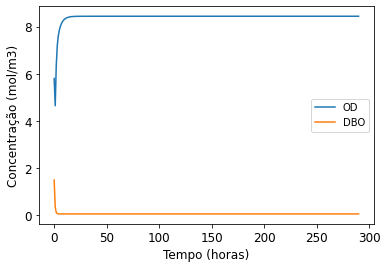

In [14]:
fig, ax = plt.subplots() 
ax.tick_params(axis='both', labelsize=12) #increase font size for ticks
plt.ylabel(r'Concentração (mol/m3)', fontsize=12) #y label
plt.xlabel(r'Tempo (horas)', fontsize=12) #y label
ax.plot(tempo, OD_lista, label='OD') 
ax.plot(tempo, L_lista, label='DBO') 
ax.legend()
#plt.savefig('concentracoes.png', dpi = 300)
plt.show()

### Solução numérica

In [15]:
# solução numérica OD/DBO


def funcao_reacao_parcial(z, t):

    L, OD = z  # Definir as variaveis

    # Constantes da reação

    V = 25.6 * (10**6)  # m3
    H = 5.6  # m
    Os = 9.0  # mg/L
    v_s = 1  # m/d
    L_F4 = 1.5  # mg/L
    L_TD4 = 1.7  # mg/L
    L_TE10 = 1.3  # mg/L
    OD_F4 = 8  # mg/L
    OD_TD4 = 8  # mg/L
    OD_TE10 = 8  # mg/L
    kd = 1.5  # d-1
    ka = 0.3  # d-1
    k_sed = v_s / H
    k_ra = 0.05  # d-1
    k_n = 0.1  # d-1
    k_g = 0.15  # d-1
    r_ca = 50  # gC/mgChla
    r_oc = 2.67  # gO/gC
    r_on = 4.2  # gO/gN
    L_n = 0.157  # mg/L
    alpha = 0.0128  # mg/L
    L_part = 0.5  # adimensional
    SOD = 1  # gO2/m2
    pa = r_oc * r_ca * k_g * alpha  # mgOD/L

    # Balanço hidrico

    Q_F4 = 2.0 * 86400  # * 1000 #m3/d
    Q_TD4 = 0.3 * 86400  # * 1000#m3/d
    Q_TE10 = 0.15 * 86400  # * 1000#m3/d

    bal_hid = Q_F4 + Q_TD4 + Q_TE10

    # Cargas externas

    carga_L = L_F4 * Q_F4 + L_TD4 * Q_TD4 + L_TE10 * Q_TE10
    carga_OD = OD_F4 * Q_F4 + OD_TD4 * Q_TD4 + OD_TE10 * Q_TE10

    # Definir as funções

    dLdt = (
        -kd * L
        + r_ca * r_oc * k_ra * alpha
        - k_sed * (1 - L_part) * L
        - (L / V) * bal_hid
        + carga_L / V
    )

    dODdt = (
        -kd * L
        + ka * (Os - OD)
        - r_on * k_n * L_n
        - r_ca * r_oc * k_ra * alpha
        - (SOD / H)
        + pa
        - (OD / V) * bal_hid
        + carga_OD / V
    )

    return dLdt, dODdt


# Condições iniciais

L0_1 = 1.5  # mg/L
OD0_1 = 5.8  # mg/L
z0_1 = L0_1, OD0_1

# Passo no tempo
t1 = np.linspace(0, 291, 291)


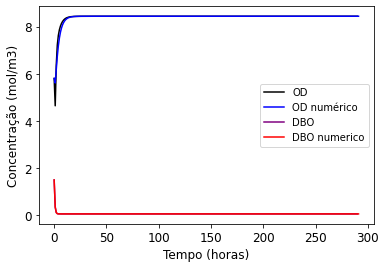

In [16]:
# Integrar as equações com odeint

funcao_teste = odeint(funcao_reacao_parcial, z0_1, t1)
L1, OD1 = funcao_teste.T

# plt.plot(t1, L1, 'r', label = 'DBO')
# plt.plot(t1, OD1, 'b', label = 'OD numérico')
# plt.plot(tempo, OD_lista, 'purble', label = "OD analitico" )
# plt.plot(tempo, L_lista,'black', label='DBO analitico')

fig1, ax1 = plt.subplots()
ax1.tick_params(axis="both", labelsize=12)  # increase font size for ticks
plt.ylabel(r"Concentração (mol/m3)", fontsize=12)  # y label
plt.xlabel(r"Tempo (horas)", fontsize=12)  # y label
ax1.plot(tempo, OD_lista, "black", label="OD")
ax1.plot(t1, OD1, "b", label="OD numérico")
ax1.plot(tempo, L_lista, "purple", label="DBO")
ax1.plot(t1, L1, "r", label="DBO numerico")
ax1.legend()
# plt.savefig('concentracoes.png', dpi = 300)
plt.show()


In [17]:
# solução analítica OD/DBO

OD_0 = 5.8
L_0 = 1.5

OD_old = 5.8
L_old = 1.5

# Constantes da equação

V = 25.6 * (10**6)  # m3
H = 5.6  # m
Os = 9.0  # mg/L
v_s = 1  # m/d
L_F4 = 1.5  # mg/L
L_TD4 = 1.7  # mg/L
L_TE10 = 1.3  # mg/L
OD_F4 = 8  # mg/L
OD_TD4 = 8  # mg/L
OD_TE10 = 8  # mg/L
kd = 1.5  # d-1
ka = 0.3  # d-1
k_sed = v_s / H
k_ra = 0.05  # d-1
k_n = 0.1  # d-1
k_g = 0.15  # d-1
r_ca = 50  # gC/mgChla
r_oc = 2.67  # gO/gC
r_on = 4.2  # gO/gN
L_n = 0.157  # mg/L
alpha = 0.0128  # mg/L
L_part = 0.5  # adimensional
SOD = 1  # gO2/m2
pa = r_oc * r_ca * k_g * alpha  # mgOD/L

# Balanço hidrico

Q_F4 = 2.0 * 86400  # * 1000 #m3/d
Q_TD4 = 0.3 * 86400  # * 1000#m3/d
Q_TE10 = 0.15 * 86400  # * 1000#m3/d

bal_hid = Q_F4 + Q_TD4 + Q_TE10

# Cargas externas

carga_L = L_F4 * Q_F4 + L_TD4 * Q_TD4 + L_TE10 * Q_TE10
carga_OD = OD_F4 * Q_F4 + OD_TD4 * Q_TD4 + OD_TE10 * Q_TE10

# Passo no tempo

t = 0
dt = 1
tmax = 291
tempo = np.arange(0, tmax, dt)

# Equação OD - dDOdt = -kd*L + ka*(Os-OD) - r_on*k_n*L_n - r_ca*r_oc*k_ra*alpha - (SOD/H) + pa  - (OD/V)*bal_hid + carga_OD/V
m_OD = ka + bal_hid / V
w_OD = (
    -kd * L_old
    + ka * Os
    - r_on * k_n * L_n
    - r_ca * r_oc * k_ra * alpha
    - (SOD / H)
    + pa
    + carga_OD / V
)

# Equação DBO - dLdt = - kd*L + r_ca*r_oc*k_ra*alpha - k_sed*(1-L_part)*L - (L/V)*bal_hid + carga_L/V
m_L = kd + bal_hid / V + k_sed * (1 - L_part)
w_L = r_ca * r_oc * k_ra * alpha + carga_L / V

# Lista vazia com os resultados calculados

OD_lista = []
L_lista = []


while t < tmax:

    OD_new = ((OD_0 * m_OD + w_OD * np.exp(m_OD * t) - w_OD) * np.exp(-m_OD * t)) / m_OD
    L_new = ((L_0 * m_L + w_L * np.exp(m_L * t) - w_L) * np.exp(-m_L * t)) / m_L

    t = t + dt

    OD_old = OD_new
    L_old = L_new

    w_OD = (
        -kd * L_old
        + ka * Os
        - r_on * k_n * L_n
        - r_ca * r_oc * k_ra * alpha
        - (SOD / H)
        + pa
        + carga_OD / V
    )

    OD_lista.append(OD_new)
    L_lista.append(L_new)


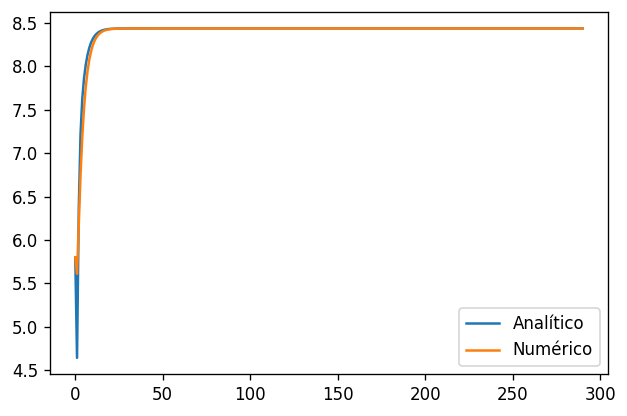

In [18]:
plt.figure(1, dpi=120)
plt.plot(tempo, OD_lista, label="Analítico")
plt.plot(tempo, OD1, label="Numérico")
plt.legend()
plt.show()




In [19]:
# from sklearn.metrics import r2_score

# r2_score(OD_lista, OD1)
# r2_score(L_lista, L1)

In [20]:
P_org_0 = 0.021
P_in_0 = 0.0039

P_org_old = 0.021
P_in_old = 0.0039

# Constantes da eq


V = 25.6 * (10**6)  # m3
H = 5.6  # m
Os = 9.0  # mg/L
v_s = 1  # m/d
k_mineral = 0.1 #d-1 
k_ra = 0.05 #d-1
k_sed = v_s/H
k_ea = 0.17 #d-1 [0.003 a 0.17]


P_org_F4 = 0.02 #mg/L
P_org_TD4 = 0.015 #mg/L
P_org_TE10 = 0.02 #mg/L
P_in_F4 = 0.01 #mg/L
P_in_TD4 = 0.015 #mg/L
P_in_TE10 = 0.01 #mg/L

r_pa = 0.5 # gP/gChla [0.5 a 1]
f_op = 0.1 #adimensional [0.1 a 0.9]


Q_F4 = 2.0  * 86400 #* 1000 #m3/d
Q_TD4 = 0.3 * 86400 #* 1000#m3/d
Q_TE10 = 0.15  * 86400# * 1000#m3/d

bal_hid = Q_F4 + Q_TD4 + Q_TE10 

carga_P_org = P_org_F4*Q_F4 + P_org_TD4*Q_TD4 + P_org_TE10*Q_TE10
carga_P_in = P_in_F4*Q_F4 + P_in_TD4*Q_TD4 + P_in_TE10*Q_TE10

# Passo no tempo

t = 0
dt = 1
tmax = 291
tempo = np.arange(0, tmax, dt)

# Equação P_org - dP_orgdt = -k_mineral_var*P_org + r_pa*k_ra_var*f_op*alpha + r_pa*k_ea*f_op*alpha + carga_P_org_var/V - (P_org/V)*bal_hid_var

m_P_org = k_mineral + bal_hid/V
w_P_org = r_pa*k_ra*f_op*alpha + r_pa*k_ea*f_op*alpha + carga_P_org/V

# Equação P_in - dP_indt = k_mineral_var*P_org - k_sed*P_in +r_pa*k_ra_var*(1-f_op)*alpha + r_pa*k_ea*(1-f_op)*alpha + carga_P_in_var/V - (P_in/V)*bal_hid_var

m_P_in = k_sed + bal_hid/V
w_P_in = k_mineral*P_org_old + r_pa*k_ra*(1-f_op)*alpha + r_pa*k_ea*(1-f_op)*alpha + carga_P_in/V

# Lista vazia

P_org_lista = []
P_in_lista = []


while t < tmax:

    P_org_new = ((P_org_0 * m_P_org + w_P_org * np.exp(m_P_org * t) - w_P_org) * np.exp(-m_P_org * t)) / m_P_org
    P_in_new = ((P_in_0 * m_P_in + w_P_in * np.exp(m_P_in * t) - w_P_in) * np.exp(-m_P_in * t)) / m_P_in

    t = t + dt

    P_org_old = P_org_new
    P_in_old = P_in_new

    w_P_in = (k_mineral*P_org_old + r_pa*k_ra*(1-f_op)*alpha + r_pa*k_ea*(1-f_op)*alpha + carga_P_in/V)
    
    P_org_lista.append(P_org_new)
    P_in_lista.append(P_in_new)




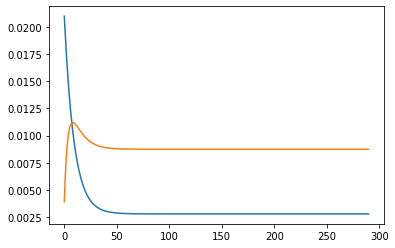

In [21]:
plt.plot(tempo, P_org_lista, label = 'P_org')
plt.plot(tempo, P_in_lista, label = 'P_in')

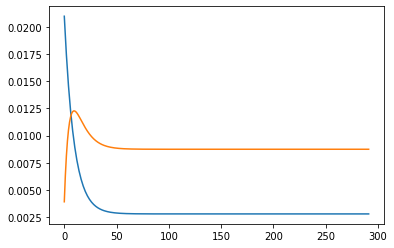

In [27]:
def funcao_fosforo(z, t):
    
    
    P_org = z[0]
    P_in = z[1]
    
    # Constantes da eq


    V = 25.6 * (10**6)  # m3
    H = 5.6  # m
    Os = 9.0  # mg/L
    v_s = 1  # m/d
    k_mineral = 0.1 #d-1 
    k_ra = 0.05 #d-1
    k_sed = v_s/H
    k_ea = 0.17 #d-1 [0.003 a 0.17]


    P_org_F4 = 0.02 #mg/L
    P_org_TD4 = 0.015 #mg/L
    P_org_TE10 = 0.02 #mg/L
    P_in_F4 = 0.01 #mg/L
    P_in_TD4 = 0.015 #mg/L
    P_in_TE10 = 0.01 #mg/L

    r_pa = 0.5 # gP/gChla [0.5 a 1]
    f_op = 0.1 #adimensional [0.1 a 0.9]


    Q_F4 = 2.0  * 86400 #* 1000 #m3/d
    Q_TD4 = 0.3 * 86400 #* 1000#m3/d
    Q_TE10 = 0.15  * 86400# * 1000#m3/d

    bal_hid = Q_F4 + Q_TD4 + Q_TE10 

    carga_P_org = P_org_F4*Q_F4 + P_org_TD4*Q_TD4 + P_org_TE10*Q_TE10
    carga_P_in = P_in_F4*Q_F4 + P_in_TD4*Q_TD4 + P_in_TE10*Q_TE10
    
    dP_orgdt = -k_mineral*P_org + r_pa*k_ra*f_op*alpha + r_pa*k_ea*f_op*alpha + carga_P_org/V - (P_org/V)*bal_hid

    dP_indt = k_mineral*P_org - k_sed*P_in +r_pa*k_ra*(1-f_op)*alpha + r_pa*k_ea*(1-f_op)*alpha + carga_P_in/V - (P_in/V)*bal_hid 
    
    return dP_orgdt, dP_indt

# Passo no tempo

n = 291
t = np.linspace(0,291,n)


z0_1 = [0.021, 0.0039]

funcao_teste = odeint(funcao_fosforo, z0_1, t)
P_org = funcao_teste[:, 0]
P_in = funcao_teste[:, 1]


plt.plot (t, P_org, label = ' p_org')
plt.plot (t, P_in, label = ' p_in')


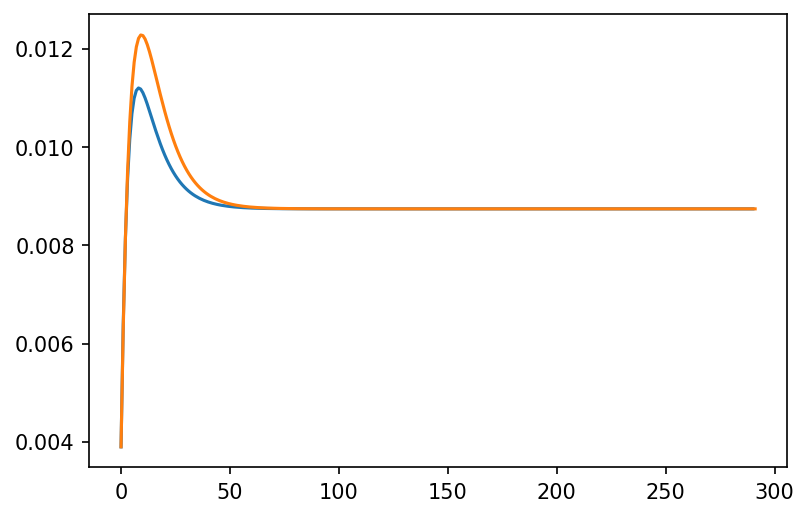

In [28]:
plt.figure(dpi = 150)
#plt.plot(tempo, P_org_lista, label = 'P_org_anal')
plt.plot(tempo, P_in_lista, label = 'P_in_anal')
# plt.plot (t, P_org, label = ' P_org')
plt.plot (t, P_in, label = ' P_in')

In [25]:
from sklearn.metrics import r2_score

r2_score(OD_lista, OD1)
r2_score(L_lista, L1)
r2_score(P_org_lista, P_org)
r2_score(P_in_lista, P_in)

0.7699466833577201